# Phat-GARCH #

I'm sure you are wondering what all this has to do with fat tails. 

We have seen evidence that equity price returns are fat-tailed and that the left tail is likely fatter than the right tail (attributed to various phenomena; see [Ding (2011)](references.ipynb).

GARCH models have thus been adjusted in an attempt to capture this phenomenon by various derivative implementations: differencing of innovations against their absolute value,  allowing for variability in the correlated moment, etc. These types of GARCH approaches do not address a key assumption that the innovations themselves are standard normally distributed. 

Other fat-tail distributions have been substituted in GARCH models: [Student's T, skewed Student's T, Extreme Value Distrubtion](references.ipynb), all of which, as we've shown previously, are less ideal than the Pareto in capturing tail propertiers. The Pareto, of course, is single-tailed so its use has typically been restricted to VaR estimation. Some approaches have used a two-tailed Pareto with a non-parametric normal density estimation in the body.

The Phat distribution improves upon this technique by introducing a fully continuous double Pareto with estimable statistical properties throughout. And so we will look to incorporate the Phat distribution into a GARCH forecast.

## Approach ##

The generally understood requirement for the distribution of innovations is simply:

$$E[e^2_{t+1}|F_t]=1$$

So, to introduce Phat innovations into the GARCH forecast:

1. Fit a standard ARMA(2,2)-GARCH(1,1) process to S&P 500 index daily returns.

2. Fit the Phat distribution to the standardized residuals of this process using the Hill Double Bootstrap and `PhatNet`.

3. Generate an ARMA-GARCH forecast using `Garchcast`, using standarized draws from the Phat distribution found in 2 for the innovations.

This approach is similar to that used by [Danielsson and Devries (1997)](references.ipynb) and outlined in [this tutorial](https://www.mathworks.com/help/econ/using-extreme-value-theory-and-copulas-to-evaluate-market-risk.html) with the key difference again being the use of a fully-parameterized distribution through the body.

## A Note on Scaling ##

As shown previously, GARCH models tend to fit daily equity returns best when scaled in percentage terms (i.e. factor of 100x). Meanwhile, the `PhatNet` custom loss function performs appropriately on smaller scales. We have found a 10x factor of the simple returns for the S&P500 index to be an appropriate scale for `PhatNet`.

***GREAT CARE SHOULD BE USED IN TRANSLATING BETWEEN THE TWO MODELS AND THEIR SCALES***

## Forecasting Time Series with Pareto Hybrids ##

### Generate ARMA-GARCH Residuals ###

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns; sns.set(style = 'whitegrid')

In [2]:
import yfinance as yf

sp = yf.download('^GSPC')
sp_ret = sp.Close.pct_change().dropna().loc['1950-01-01':]*100

[*********************100%***********************]  1 of 1 completed


In [3]:
from statsmodels.tsa.stattools import adfuller

adf, p_value, _, _, crit, _ = adfuller(sp_ret, regression='ct')
adf, crit['1%'], p_value

(-23.66749628832771, -3.959274242553392, 0.0)

We will fit the ARMA(2,2) residuals to an ARCH(1,1) across 7 windows of fixed length.

In [4]:
import pandas as pd
import pmdarima

arma22 = pmdarima.ARIMA((2,0,2)).fit(sp_ret)
arma22_resids = pd.Series(arma22.resid(), index=sp_ret.index)

/Users/spindicate/.pyenv/versions/3.9.0/envs/phatpack/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/spindicate/.pyenv/versions/3.9.0/envs/phatpack/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [5]:
import numpy as np
import arch

from tqdm.auto import trange

n_windows = 7
window = int(arma22_resids.size / n_windows)
windex = np.array([np.arange(i*window, (i+1)*window) for i in range(n_windows)])

garch_resids = np.zeros((n_windows, window))
for i in trange(n_windows):
    arch11 = arch.arch_model(arma22_resids[windex[i]], p=1, q=1).fit(disp='off')
    garch_resids[i] = arch11.std_resid

  0%|          | 0/7 [00:00<?, ?it/s]

### Fit Residuals to Phat Distribution ###

We flatten the residuals and reduce the scale by 10x, then estimate both the left and right tails via the Hill Double Bootstrap.

In [6]:
from phat import DataSplit, two_tailed_hill_double_bootstrap

resids_for_phat = garch_resids.flatten() / 10
data = DataSplit(resids_for_phat)

xil, xir = two_tailed_hill_double_bootstrap(resids_for_phat)

2021-07-22 14:20:46.802994: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
import tensorflow as tf
from phat import PhatNet, PhatMetric, PhatLoss

nnet = PhatNet(neurons=1)

metrics = [
    PhatMetric('shape_left'), PhatMetric('shape_right'),
    PhatMetric('mean_left'), PhatMetric('std_left'),  
]
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
nnet.compile(loss=PhatLoss(xil.mean(),xir.mean()), optimizer=optimizer, metrics=metrics)

history = nnet.fit(
    data.train, 
    epochs=100,
    validation_data=data.test,
    verbose=1
)

Epoch 1/100


2021-07-22 14:21:05.568799: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


456/456 [==============================] - 5s 4ms/step - loss: 0.3421 - shape_left: 1.0005 - shape_right: 0.9332 - mean_left: -0.0116 - std_left: 0.5660 - val_loss: 0.2619 - val_shape_left: 1.0012 - val_shape_right: 0.9338 - val_mean_left: -0.0115 - val_std_left: 0.5657
Epoch 2/100
456/456 [==============================] - 1s 2ms/step - loss: 0.1977 - shape_left: 1.3827 - shape_right: 1.2301 - mean_left: -0.0096 - std_left: 0.4163 - val_loss: 0.1404 - val_shape_left: 1.3836 - val_shape_right: 1.2308 - val_mean_left: -0.0095 - val_std_left: 0.4160
Epoch 3/100
456/456 [==============================] - 1s 2ms/step - loss: 0.0941 - shape_left: 1.7634 - shape_right: 1.5246 - mean_left: -0.0087 - std_left: 0.2795 - val_loss: 0.0521 - val_shape_left: 1.7641 - val_shape_right: 1.5252 - val_mean_left: -0.0085 - val_std_left: 0.2792
Epoch 4/100
456/456 [==============================] - 1s 2ms/step - loss: 0.0169 - shape_left: 2.0392 - shape_right: 1.7266 - mean_left: -0.0077 - std_left: 0.175

Network results in:

In [8]:
nnet.predicted_params()

,
mean,-0.002341
sig,0.036168
shape_l,0.219452
shape_r,0.172152


We can check the results against a straight-forward `MLE` using `fit` in the `Phat` distribution:

In [9]:
from phat import Phat

mle = Phat.fit(garch_resids.flatten()/10, xil, xir)
mle.summary()

Optimization terminated successfully.
         Current function value: -0.819832
         Iterations: 31
         Function evaluations: 62


<class 'statsmodels.iolib.summary.Summary'>
"""
                               PhatFit Results                                
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                 14749.
Model:                        PhatFit   AIC:                        -2.950e+04
Method:            Maximum Likelihood   BIC:                        -2.949e+04
Date:                Thu, 22 Jul 2021                                         
Time:                        14:21:24                                         
No. Observations:               17990                                         
Df Residuals:                   17989                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.81e-05      0.001      0.045      0.964      -0.001       0.001
x1             0.0363      0.000     98.494      0.000       0.036       0.037
==============================================================================
"""

MLE provides fairly similar outputs, however, the mean value is not statistically significant. This results from a scaling issue.

### Some More Notes on Scaling ###

We "descaled" our garch residuals in order to fit the Phat distribution. To translate back to the garch residuals, we must rescale by a factor of 10. We found that scaling both `mu` and `std` parameters found in the Garch fit leads to the exact same distribution as scaling a sample of random draw by 10.

In [10]:
mu, std, l, r = nnet.predicted_params().values[:, 0]
phat1 = Phat(mu, std, l, r)
phat2 = Phat(mu*10, std*10, l, r)

n = 10000000
rv1 = phat1.rvs(n)*10
rv2 = phat2.rvs(n)

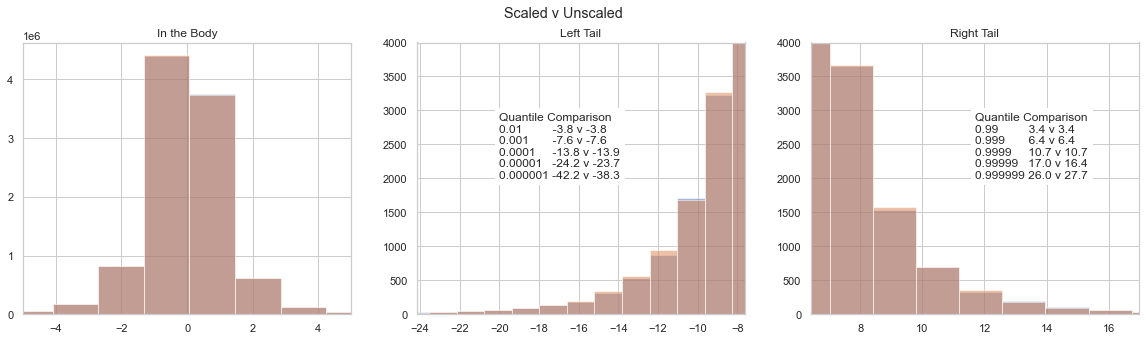

In [11]:
import matplotlib.pyplot as plt

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))

_, bins, _ = ax1.hist(rv1, bins=100, alpha=.5)
_, _, _ = ax1.hist(rv2, bins=bins, alpha=.5)
ax1.set_xlim(-5,5)

_, bins, _ = ax2.hist(rv1, bins=100, alpha=.5)
_, _, _ = ax2.hist(rv2, bins=bins, alpha=.5)

l_crit = 1/np.logspace(2,6,5)
r_crit = 1 - l_crit

s1_qs, s2_qs = np.quantile(rv1, l_crit), np.quantile(rv2, l_crit)

txt = 'Quantile Comparison'
i = 0
for crit, s1q, s2q in zip(l_crit, s1_qs, s2_qs):
    i += 1
    txt += '\n'
    txt += f'{crit:.6f}'.rstrip("0") + ' '*(10-i*2) + f' {s1q:.1f} v {s2q:.1f}'

ax2.text(.25, .5, txt, transform=ax2.transAxes, bbox=dict(facecolor='w'))

ax2.set_xlim(s1_qs[3], s1_qs[1])
ax2.set_ylim(0,4000)

_, bins, _ = ax3.hist(rv1, bins=100, alpha=.5)
_, _, _ = ax3.hist(rv2, bins=bins, alpha=.5)

s1_qs, s2_qs = np.quantile(rv1, r_crit), np.quantile(rv2, r_crit)
txt = 'Quantile Comparison'
i = 0
for crit, s1q, s2q in zip(r_crit, s1_qs, s2_qs):
    i += 1
    txt += '\n'
    txt += f'{crit:.6f}'.rstrip("0") + ' '*(10-i*2) + f' {s1q:.1f} v {s2q:.1f}'

ax3.text(.5, .5, txt, transform=ax3.transAxes, bbox=dict(facecolor='w'))

ax3.set_xlim(s1_qs[1], s1_qs[3])
ax3.set_ylim(0,4000)

ax1.set_title('In the Body')
ax2.set_title('Left Tail')
ax3.set_title('Right Tail')
plt.suptitle('Scaled v Unscaled')

plt.show()

We can confirm this with the Anderson-Darliing test for k-samples from `scipy`. The null hypothesis is that the two samples come from the same distribution.

In [12]:
import scipy.stats as scist

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    phats_ad = scist.anderson_ksamp((
        rv1*10,
        rv2
    ))
phats_ad

Anderson_ksampResult(statistic=2351191.7739877934, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

Per the result, we cannot reject that the two samples come from the same distribution. Thus, for convenience going forward, we will scale the PhatNet `mu` and `std` parameter outputs by 10.

### Comparing Fit ###

We will compare the fit of the residuals to the Phat distribution with that of the Normal by first assessing quantiles.

In [13]:
phat_dist = Phat(mu*10, std*10, l, r)

norm_params = scist.norm.fit(garch_resids.flatten())
normfit = scist.norm(*norm_params)

l_crit = 1/np.logspace(2,5,4)
r_crit = 1 - l_crit

l_act = np.quantile(garch_resids.flatten(), l_crit)
nl_act = [(garch_resids.flatten() < q).sum() for q in l_act]

df_lcrit = pd.DataFrame([
    nl_act,
    l_act,
    phat_dist.ppf(l_crit), 
    normfit.ppf(l_crit),
], index=['# Obs', 'Acutal', 'Phat', 'Gaussian'], columns=l_crit).T

r_act = np.quantile(garch_resids.flatten(), r_crit)
nr_act = [(garch_resids.flatten() > q).sum() for q in r_act]
df_rcrit = pd.DataFrame([
    nr_act,
    r_act,
    phat_dist.ppf(r_crit), 
    normfit.ppf(r_crit),
], index=['# Obs', 'Acutal', 'Phat', 'Gaussian'], columns=r_crit).T

df_crit = pd.concat((df_lcrit[::-1], df_rcrit))

df_crit

,# Obs,Acutal,Phat,Gaussian
0.00001,1.0,-10.709841,-24.027065,-4.298390
0.00010,2.0,-8.746265,-13.829903,-3.752760
0.00100,18.0,-4.513212,-7.620983,-3.124258
0.01000,180.0,-2.626984,-3.800277,-2.360716
0.99000,180.0,2.290373,3.391494,2.289893
0.99900,18.0,3.345706,6.377107,3.053435
0.99990,2.0,5.084851,10.716120,3.681937
0.99999,1.0,7.188570,17.091940,4.227567


We can see the quantile values of the actual observations lie somewhere between the Phat and the Normal. The left tail of the Phat also exhibits better fit, to be expected given it has a larger tail index.

We can also check the Anderson-Darling k-sample test for both distributions using draws of standardized random variables.

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    
    norm_ad = scist.anderson_ksamp((
        garch_resids.flatten(), 
        normfit.rvs(size=1000000)/normfit.std()
    ))
    phat_ad = scist.anderson_ksamp((
        garch_resids.flatten(),
        phat_dist.std_rvs(size=1000000)
    ))

norm_ad, phat_ad

(Anderson_ksampResult(statistic=58.95183955377454, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001),
 Anderson_ksampResult(statistic=121.7176674133422, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001))

We cannot reject the null for either distribution (that it is the true distribution), but the `Phat` does have a larger statistic.

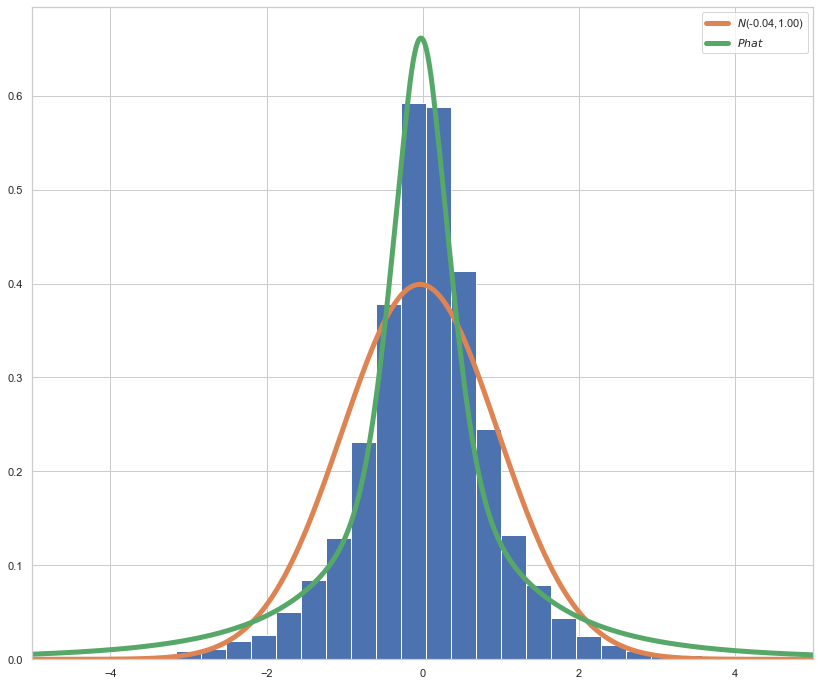

In [15]:
fig, ax = plt.subplots(1,1, figsize=(14,12))

plt.hist(sp_ret, bins=100, density=True)

x = np.linspace(-5, 5, 1000)
ax.plot(
    x, normfit.pdf(x), c='C1', lw=5,
    label=r'$N$'+f'({normfit.args[0]:.2f},{normfit.args[1]:.2f})')
ax.plot(
    x, phat_dist.pdf(x), c='C2', lw=5,
    label=r'$Phat$'
)

ax.set_xlim(-5,5)

ax.legend()
plt.show()

We can see consistent with the quantile finds that the Phat performs better than the Gaussian over the head and tail, but underperforms with respecect to the shoulder.

### Phatcast ###

Now we have enough to generate an ARMA-GARCH forecast with Phat residuals. We will compare the forecast to the standard Gaussian residuals visually.

In [16]:
from phat import Garchcaster
 
n = 10000
days = 252

mod = Garchcaster(
    garch_resids.flatten().copy(), 
    arch11.conditional_volatility.values.copy(),
    arch11.resid.values.copy(),
    arma22.params()[:5],
    arch11.params.values,
    iters=n,
    periods=days,
)
res1 = mod.forecast(dist=phat_dist)
res2 = mod.forecast()

Below, we compare on a 1-year time horizon (252 days).

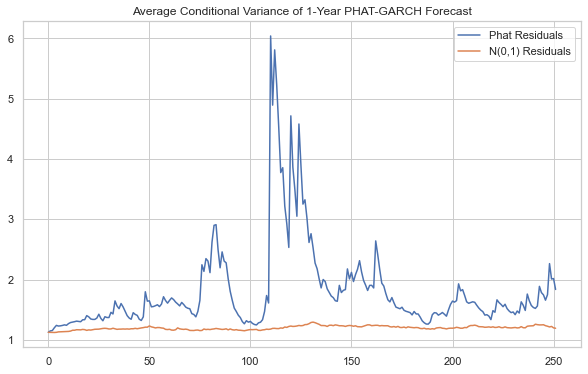

In [17]:
plt.figure(figsize=(10,6))
plt.plot((res1.vols**2).T.mean(axis=1), label='Phat Residuals')
plt.plot((res2.vols**2).T.mean(axis=1), label='N(0,1) Residuals')

plt.legend()
plt.title('Average Conditional Variance of 1-Year PHAT-GARCH Forecast')
plt.show()

Obviously, for the long-term forecasts, the Phat distribution creates a much more "natural" volatility with short, dramatic spikes, whole periods of elevated levels of volatility, and prolonged periods of sustained, declining and low volatility.

Now for 10-years. We show the full spectrum on the left-hand side, then zoom in on the right to show the difference in volatility day-to-day.

In [18]:
res3 = mod.forecast(dist=phat_dist, periods=days*10)
res4 = mod.forecast(periods=days*10)

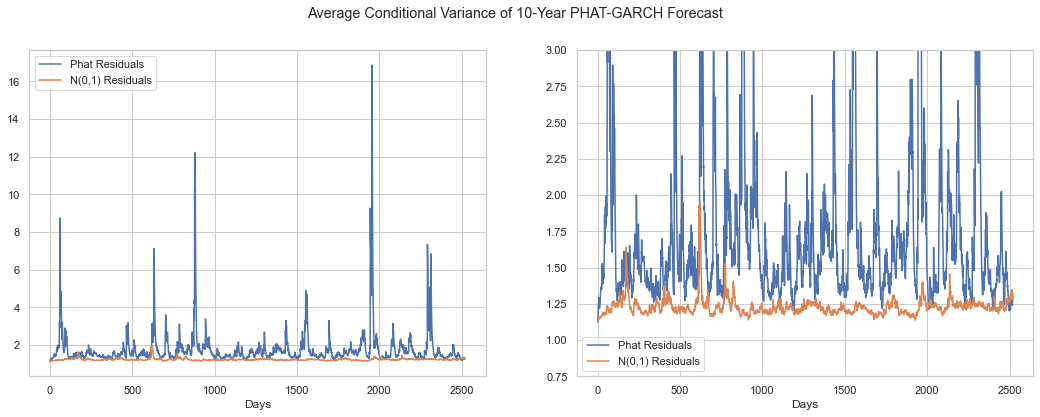

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot((res3.vols**2).T.mean(axis=1), label='Phat Residuals')
ax1.plot((res4.vols**2).T.mean(axis=1), label='N(0,1) Residuals')

ax2.plot((res3.vols**2).T.mean(axis=1), label='Phat Residuals')
ax2.plot((res4.vols**2).T.mean(axis=1), label='N(0,1) Residuals')
ax2.set_ylim(.75,3)

ax1.set_xlabel('Days')
ax2.set_xlabel('Days')
ax1.legend()
ax2.legend()
plt.suptitle('Average Conditional Variance of 10-Year PHAT-GARCH Forecast')
plt.show()

We can see again from the above that the "natural" volatility process continues for many periods, well after the standard Gaussian has found a stable range. 

The variance values above may seem dramatic but relative to the spikes seen in 2020 and 2008, they may even be conservative.

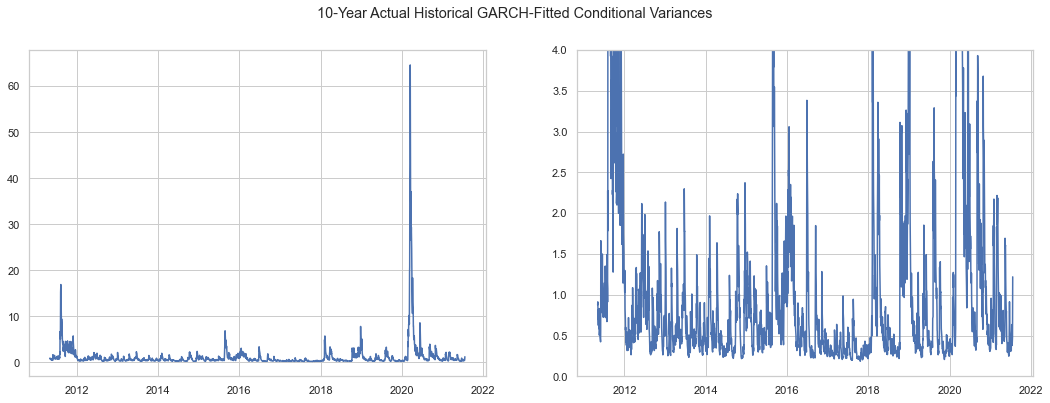

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(arch11.conditional_volatility**2)

ax2.plot(arch11.conditional_volatility**2)
ax2.set_ylim(0,4)

plt.suptitle('10-Year Actual Historical GARCH-Fitted Conditional Variances')
plt.show()

In the right-handed subplot we can see one major weakness of our approach: the conditional variance of the S&P500 over the last 15 years spent extended periods below 1x and was, in general, more volatile between the range of .5 and 2x than is produced by the Phat distribution.

This is a well-understood effect of ARCH models and has led to its various extentions over time: GARCH, IGARCH, TGARCH, EGARCH etc.

To address this in the future, we might consider:

1. Introducing the Phat distribution during the fit
2. Utilizing a truncated Phat distribution
3. Employing the other derivative Garch processes.

Still, despite this drawback, we clearly have evidenced of a more realistic process.

We can replicate this outcome in `arch` to confirm.

In [21]:
def custom_rng(phat):
    def _rng(size):
        shocks = phat.std_rvs(size=size)
        return shocks
    return _rng

In [22]:
sim1 = arch11.forecast(
    horizon=days,
    simulations=n,
    rng=custom_rng(phat_dist),
    method='simulation',
    reindex=False
)

sim2 = arch11.forecast(
    horizon=days,
    simulations=n,
    method='simulation',
    reindex=False
)

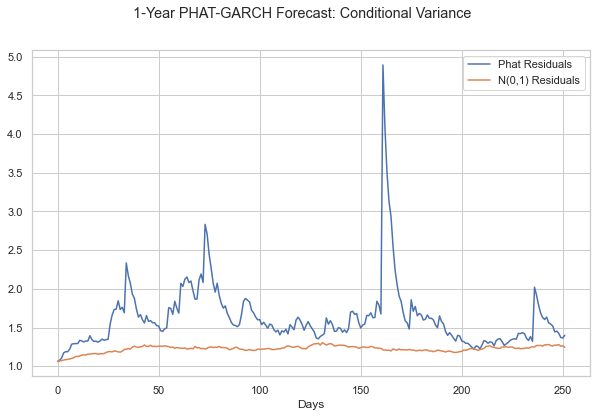

In [23]:
fig, ax1 = plt.subplots(1,1,figsize=(10,6))

ax1.plot(sim1.variance.values.T, label='Phat Residuals')
ax1.plot(sim2.variance.values.T, label='N(0,1) Residuals')

ax1.set_xlabel('Days')
ax1.legend()

plt.suptitle('1-Year PHAT-GARCH Forecast: Conditional Variance')
plt.show()

### 1-Year Price Forecast ###

We can generate price forecasts simply by calling the `plot` method on our `GarchcasterResults` containers. First, we show 4 sample simulations, assuming a starting price of $1.

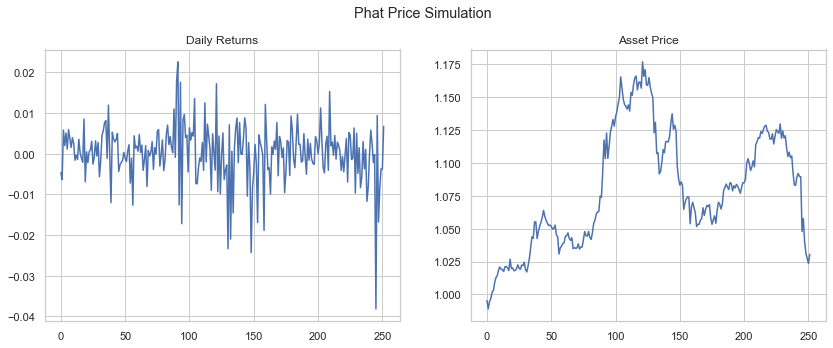

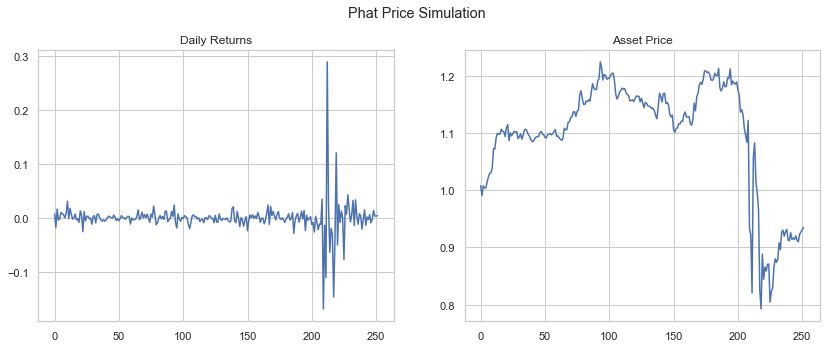

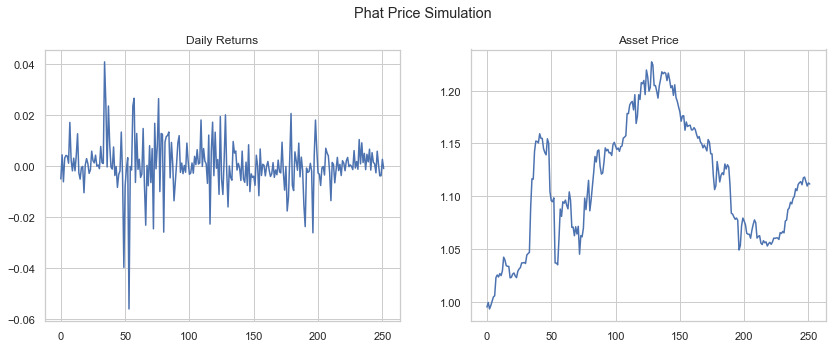

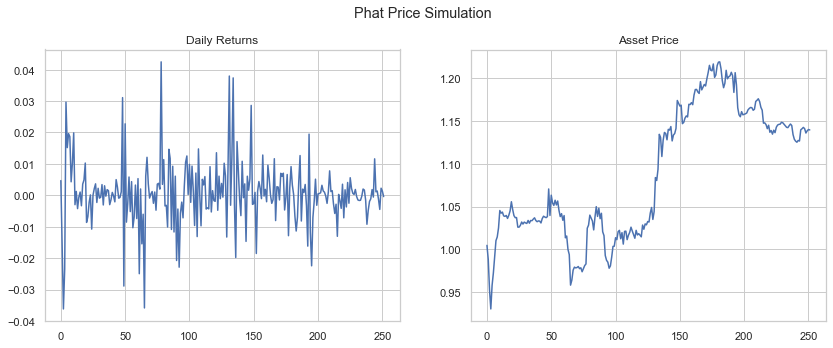

In [24]:
axes = res1.plot('price', p=1, n=4)

Below we show the end price distribution.

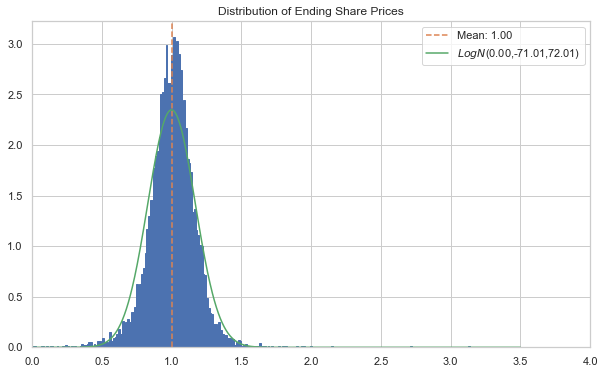

In [37]:
ax, S, bins = res1.plot('end_price', p=1)
plt.rcParams['patch.edgecolor'] = 'C0'
ax.axvline(S[:, -1].mean(), c='C1', ls='--', label=f'Mean: {S[:, -1].mean():.2f}')


logps = scist.lognorm.fit(S[:, -1])
x = np.linspace(0, 3.50, 1000)
lnormfit = scist.lognorm.pdf(x, *logps)
ax.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ax.set_xlim(0,4.00)

ax.legend()
plt.show()

Note three things from above:

1. The right tail has much higher values than the [Gaussian residual forecast](garch.ipynb#Integrated-ARMA-GARCH-Forecasts-with-Garchcaster); they simply aren't visible
2. Because of the much thicker tails, the lognormal fit is completely meaningless. The lognormal simply cannot replicate the distribution appropriately.
3. Despite having much higher values in the tails, the mean of this distribution is actually *lower* [than the Guassian residual forecast](garch.ipynb#Integrated-ARMA-GARCH-Forecasts-with-Garchcaster).

Now, again, comparing quantiles, we see the impact of Phat tail volatility on the extremes. The extreme quantiles are much more power-law *like*.

In [38]:
l_crit = 1/np.logspace(1,5,5)
r_crit = 1 - l_crit
qs = np.concatenate((l_crit[::-1], r_crit))
logqs = scist.lognorm(*logps).ppf(qs)

actual = np.quantile(S[:,-1], qs)
pd.DataFrame(list(zip(logqs, actual)), index=qs, columns=['Lognorm', 'PHAT-GARCH'])

,Lognorm,PHAT-GARCH
0.00001,0.279084,-1.867990
0.00010,0.370964,-0.092586
0.00100,0.476945,0.102945
0.01000,0.605909,0.527333
0.10000,0.782675,0.815474
0.90000,1.218169,1.189928
0.99000,1.396446,1.412181
0.99900,1.527069,1.773239
0.99990,1.634767,2.721758
0.99999,1.728393,3.096979


Here we see the tail regions of a 1-year price forecast are *dramatically* larger, however, likely more realistic. 

+ an ~50% decline is expected about once every hundred years, which maps fairly well onto the S&P 500, which has seen just one annual period of >50% declines since 1950 (and two others fairly close). 

+ a decline of ~87% is expected once every 1,000 years, which has not happened in the history of the S&P, although of course the index did lose ~90% of its value over a three-year period during the Great Depression. Under Guassian innovations, this is essentially impossible.

## PHAT-ARGARCH ##

In an effort to show the whole process in a more condensed fashion, we will fit and forecast using the `arch` packages internal `AR-GARCH` fitting model, which should provide more efficient and accurate fit for both `AR` and `GARCH` parameters, though it might ignore some mean correlation.

In [39]:
ar = arch.univariate.ARX(sp_ret, lags=[1,2])
ar.volatility = arch.univariate.GARCH(p=1, q=1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                  Close   R-squared:                      -0.007
Mean Model:                        AR   Adj. R-squared:                 -0.007
Vol Model:                      GARCH   Log-Likelihood:               -21605.9
Distribution:                  Normal   AIC:                           43223.9
Method:            Maximum Likelihood   BIC:                           43270.7
                                        No. Observations:                17989
Date:                Thu, Jul 22 2021   Df Residuals:                    17986
Time:                        14:24:05   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0507  6.092e-03      8.315  9.205e-

In [40]:
data = DataSplit(res.std_resid.values[2:]/10)
xil, xir = two_tailed_hill_double_bootstrap(data.raw.y)

  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
nnet = PhatNet(neurons=1)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
nnet.compile(loss=PhatLoss(xil, xir), optimizer=optimizer)
history = nnet.fit(
    data.train, 
    epochs=100,
    validation_data=data.test,
    verbose=0
)

Epoch 00012: early stopping


We show a 1-year forecast.

In [42]:
mu, std, l, r = nnet.predicted_params().values[:, 0]
phat_dist = Phat(mu*10, std*10, l, r)

n = 10000
days = 252

mod = Garchcaster(
    data.raw.y[2:].copy()*10, 
    res.conditional_volatility.values[2:].copy(),
    res.resid.values[2:].copy(),
    res.params[:3].values,
    res.params[[0,3,4,5]].values,
    iters=n,
    periods=days,
    order=(2,0,1,1),
)
arres = mod.forecast(dist=phat_dist)

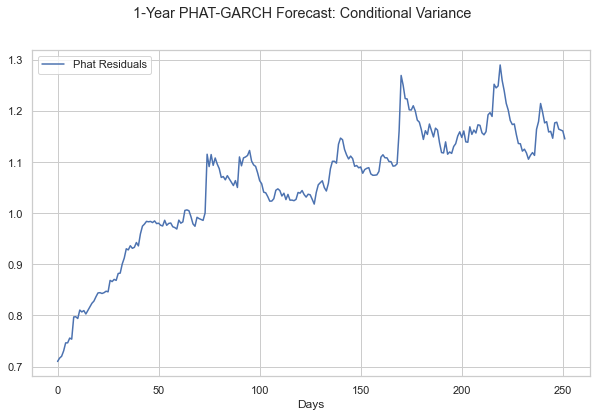

In [43]:
fig, ax1 = plt.subplots(1,1,figsize=(10,6))

ax1.plot((arres.vols**2).mean(axis=0).T, label='Phat Residuals')

ax1.set_xlabel('Days')
ax1.legend()

plt.suptitle('1-Year PHAT-GARCH Forecast: Conditional Variance')
plt.show()

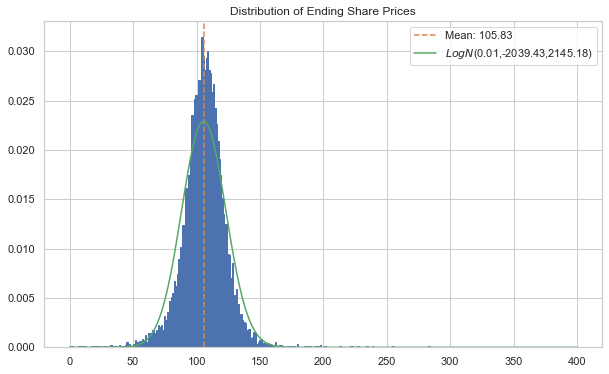

In [44]:
ax, S_phat, bins = arres.plot('end_price', p=100)

ax.axvline(S_phat[:, -1].mean(), c='C1', ls='--', label=f'Mean: {S_phat[:, -1].mean():.2f}')

logps = scist.lognorm.fit(S_phat[:, -1])
x = np.linspace(.25, 400, 1000)
lnormfit = scist.lognorm.pdf(x, *logps)
ax.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ax.legend()
plt.show()

plt.show()

In [45]:
l_crit = 1/np.logspace(1,5,5)
r_crit = 1 - l_crit
qs = np.concatenate((l_crit[::-1], r_crit))
logqs = scist.lognorm(*logps).ppf(qs)

arres_actual = np.quantile(S_phat[:,-1], qs)
pd.DataFrame(list(zip(logqs, arres_actual)), index=qs, columns=['Lognorm', 'PHAT-GARCH'])

,Lognorm,PHAT-GARCH
0.00001,32.774558,0.247967
0.00010,41.975006,1.517206
0.00100,52.623498,19.978024
0.01000,65.633241,57.508656
0.10000,83.558303,86.620947
0.90000,128.181410,124.396045
0.99000,146.639085,149.275233
0.99900,160.233477,198.179463
0.99990,171.486983,254.650209
0.99999,181.303306,280.949411


And a 5-year forecast.

In [46]:
arres5 = mod.forecast(dist=phat_dist, periods=252*5)

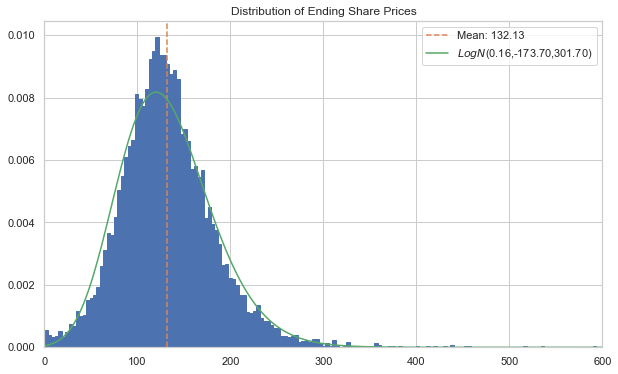

In [47]:
ax, S_5, bins = arres5.plot('end_price', p=100)

ax.axvline(S_5[:, -1].mean(), c='C1', ls='--', label=f'Mean: {S_5[:, -1].mean():.2f}')

logps = scist.lognorm.fit(S_5[:, -1])
x = np.linspace(0, 1000, 1000)
lnormfit = scist.lognorm.pdf(x, *logps)
ax.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ax.set_xlim(0,600)
ax.legend()
plt.show()

plt.show()

In [48]:
l_crit = 1/np.logspace(1,5,5)
r_crit = 1 - l_crit
qs = np.concatenate((l_crit[::-1], r_crit))
logqs = scist.lognorm(*logps).ppf(qs)

S5_actual = np.quantile(S_5[:,-1], qs)
pd.DataFrame(list(zip(logqs, S5_actual)), index=qs, columns=['Lognorm', 'PHAT-ARGARCH'])

,Lognorm,PHAT-ARGARCH
0.00001,-23.779362,-28.374991
0.00010,-9.740707,-1.623294
0.00100,8.067080,0.158079
0.01000,32.323054,22.717759
0.10000,70.824290,73.921486
0.90000,198.568988,193.962015
0.99000,268.138694,281.466092
0.99900,327.100923,419.135588
0.99990,381.494483,592.235475
0.99999,433.484415,895.319412


Pay close attention to the bulge in values around $0. The Phat-ARGARCH suggests outright, complete loss is materially more likely than the Gaussian innvoations.

## T v Phat-ARGARCH ##

We will compare the Phat-ARGARCH results to an AR-GARCH fit using the Student's T. 

In [49]:
targarch = arch.univariate.ARX(sp_ret, lags=[1,2])
targarch.distribution = arch.univariate.StudentsT()

targarch.volatility = arch.univariate.GARCH(p=1, q=1)
tres = targarch.fit(update_freq=0, disp="off")
print(tres.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                        Close   R-squared:                      -0.006
Mean Model:                              AR   Adj. R-squared:                 -0.006
Vol Model:                            GARCH   Log-Likelihood:               -21094.0
Distribution:      Standardized Student's t   AIC:                           42202.0
Method:                  Maximum Likelihood   BIC:                           42256.6
                                              No. Observations:                17989
Date:                      Thu, Jul 22 2021   Df Residuals:                    17986
Time:                              14:24:56   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

In [50]:
n = 10000
days = 252
mod = Garchcaster(
    sp_ret.values[2:],
    tres.conditional_volatility.values[2:].copy(),
    tres.resid.values[2:].copy(),
    tres.params[:3].values,
    tres.params[[0,3,4,5]].values,
    iters=n,
    periods=days,
    order=(2,0,1,1),
)

We can incorporate the fitted T distribution into `Garchcast` simply by generating standardized random variables from it and passing them to `innovs`. We will do this for both 1-year and 5-year periods.

In [51]:
t_dist = scist.t(tres.params[-1])
tfore1 = mod.forecast(innovs=t_dist.rvs((n, days))/t_dist.std())
tfore2 = mod.forecast(innovs=t_dist.rvs((n, days*5))/t_dist.std(), periods=days*5)

The variance is given below.

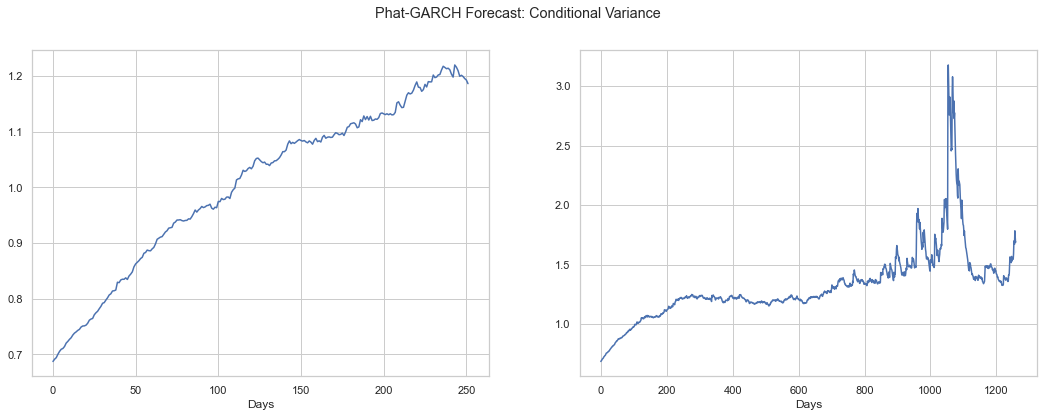

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))
ax1 = tfore1.plot('var', ax=ax1)
ax2 = tfore2.plot('var', ax=ax2)

plt.show()

The variance takes more than a year to climb to a stable range, then does exhibit some more "natural" variation around that stable value, although we do not see a single peak, $\sigma^2 > 1.6$ over the course of ten years.

The S&P 500, of course, exhibited several such peaks [in the just the past 15 years](#Phatcast) and the Phat distribution is able to produce them while the T is not.

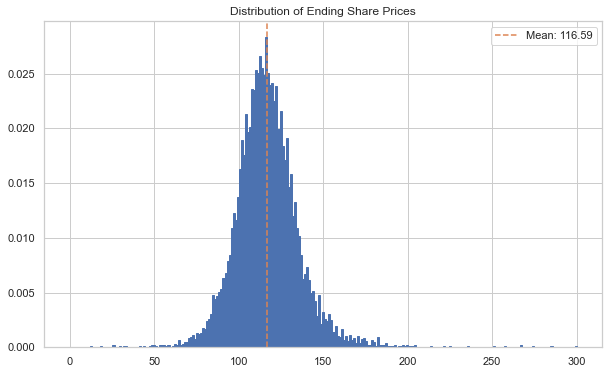

In [53]:
ax, S_t, bins = tfore1.plot('end_price', p=100)

ax.axvline(S_t[:, -1].mean(), c='C1', ls='--', label=f'Mean: {S_t[:, -1].mean():.2f}')

# logps = scist.lognorm.fit(S_t[:, -1])
# x = np.linspace(.1, 400, 1000)
# logps = list(logps)

# lnormfit = scist.lognorm.pdf(x, *logps)
# ax.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ax.legend()
plt.show()

In [54]:
l_crit = 1/np.logspace(1,5,5)
r_crit = 1 - l_crit
qs = np.concatenate((l_crit[::-1], r_crit))
logqs = scist.lognorm(*logps).ppf(qs)

St_actual = np.quantile(S_t[:,-1], qs)
pd.DataFrame(list(zip(St_actual, arres_actual)), index=qs, columns=['T-GARCH', 'PHAT-ARGARCH'])

,T-GARCH,PHAT-ARGARCH
0.00001,12.798823,0.247967
0.00010,18.486801,1.517206
0.00100,48.577769,19.978024
0.01000,74.134470,57.508656
0.10000,95.814902,86.620947
0.90000,137.920078,124.396045
0.99000,171.591507,149.275233
0.99900,213.910638,198.179463
0.99990,284.494394,254.650209
0.99999,298.531180,280.949411


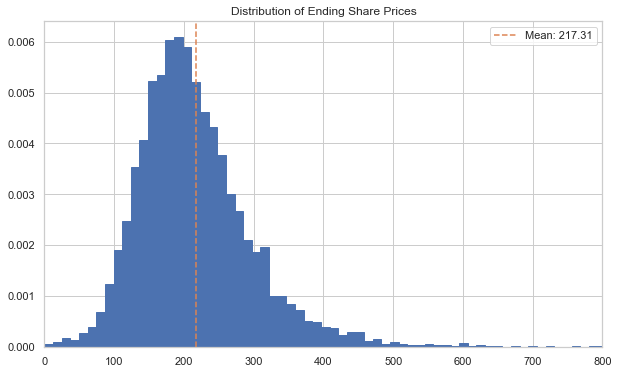

In [55]:
ax, S_t5, bins = tfore2.plot('end_price', p=100)

ax.axvline(S_t5[:, -1].mean(), c='C1', ls='--', label=f'Mean: {S_t5[:, -1].mean():.2f}')

ax.set_xlim(0, 800)

ax.legend()
plt.show()

In [56]:
l_crit = 1/np.logspace(1,5,5)
r_crit = 1 - l_crit
qs = np.concatenate((l_crit[::-1], r_crit))
logqs = scist.lognorm(*logps).ppf(qs)

St5_actual = np.quantile(S_t5[:,-1], qs)
pd.DataFrame(list(zip(St5_actual, S5_actual)), index=qs, columns=['T-GARCH', 'PHAT-ARGARCH'])

,T-GARCH,PHAT-ARGARCH
0.00001,-0.163935,-28.374991
0.00010,-0.000018,-1.623294
0.00100,11.970715,0.158079
0.01000,62.862568,22.717759
0.10000,126.254165,73.921486
0.90000,317.597778,193.962015
0.99000,501.856398,281.466092
0.99900,832.915605,419.135588
0.99990,2479.555807,592.235475
0.99999,3024.149748,895.319412


## Skew T v Phat-ARGARCH ##

We will compare the Phat-ARGARCH results to an AR-GARCH fit using the Student's T. 

In [57]:
skargarch = arch.univariate.ARX(sp_ret, lags=[1,2])
skargarch.distribution = arch.univariate.SkewStudent()

skargarch.volatility = arch.univariate.GARCH(p=1, q=1)
skres = skargarch.fit(update_freq=0, disp="off")
print(skres.summary())

                                 AR - GARCH Model Results                                
Dep. Variable:                             Close   R-squared:                      -0.005
Mean Model:                                   AR   Adj. R-squared:                 -0.006
Vol Model:                                 GARCH   Log-Likelihood:               -21079.5
Distribution:      Standardized Skew Student's t   AIC:                           42174.9
Method:                       Maximum Likelihood   BIC:                           42237.3
                                                   No. Observations:                17989
Date:                           Thu, Jul 22 2021   Df Residuals:                    17986
Time:                                   14:25:13   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------

`Garchcast` does not support the Skew-T (mainly because it's a real pain to implement in `python`), so we will use `arch` to forecast as well. 

We will do this for both 1-year and 5-year periods.

In [58]:
n = 10000
days = 252

skfore1 = tres.forecast(horizon=days, simulations=n, method='simulation', reindex=False)
skfore2 = tres.forecast(horizon=days*5, simulations=n, method='simulation', reindex=False)

The variance is given below.

In [59]:
skfore1.variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.243,h.244,h.245,h.246,h.247,h.248,h.249,h.250,h.251,h.252
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-22,0.676043,0.68216,0.686521,0.688282,0.691739,0.696331,0.700215,0.70407,0.708367,0.709706,...,1.364586,1.348415,1.344692,1.341368,1.327228,1.34516,1.368343,1.358245,1.35595,1.35241


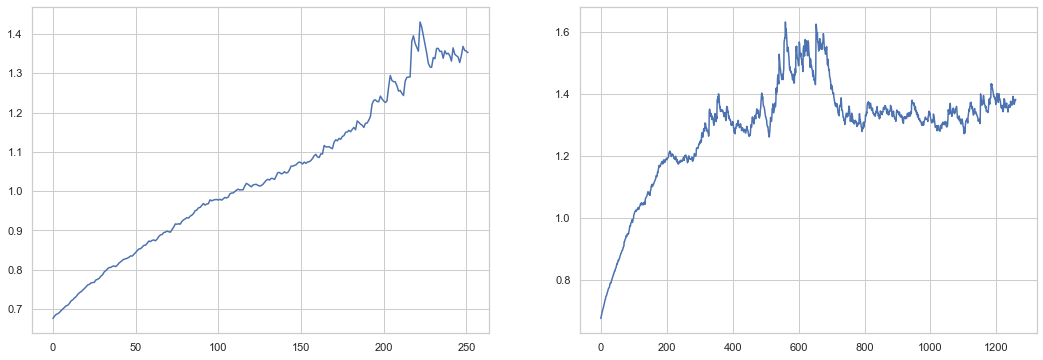

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(np.arange(days).reshape(-1,1), skfore1.variance.T.values)
ax2.plot(np.arange(days*5).reshape(-1,1), skfore2.variance.T.values)

plt.show()

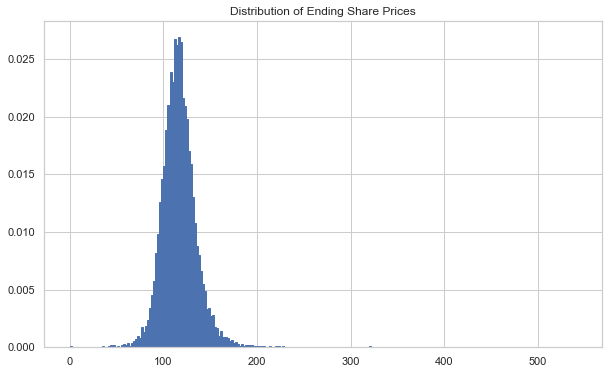

In [61]:
from phat.utils import PriceSim

simmer = PriceSim(p0=100, rets=1 + skfore1.simulations.values[0]/100)
r, S_skew, (ax, bins)= simmer.sims(show_chart=True)

In [62]:
l_crit = 1/np.logspace(1,5,5)
r_crit = 1 - l_crit
qs = np.concatenate((l_crit[::-1], r_crit))
logqs = scist.lognorm(*logps).ppf(qs)

Sk_actual = np.quantile(S_skew[:,-1], qs)
pd.DataFrame(list(zip(Sk_actual, arres_actual)), index=qs, columns=['T-GARCH', 'PHAT-ARGARCH'])

,T-GARCH,PHAT-ARGARCH
0.00001,1.293157,0.247967
0.00010,2.157295,1.517206
0.00100,44.586454,19.978024
0.01000,73.445292,57.508656
0.10000,95.985009,86.620947
0.90000,138.356970,124.396045
0.99000,172.295480,149.275233
0.99900,234.118276,198.179463
0.99990,360.222099,254.650209
0.99999,523.577420,280.949411


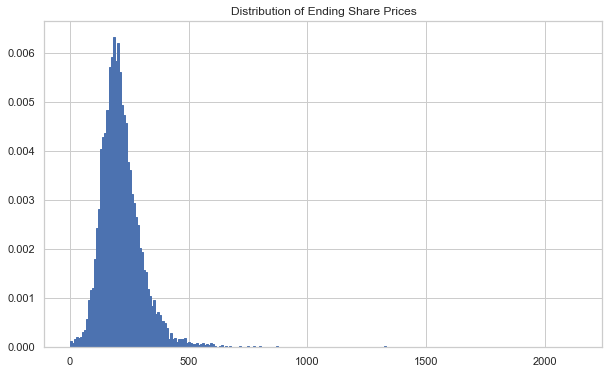

In [63]:
simmer = PriceSim(p0=100, rets=1 + skfore2.simulations.values[0]/100)
r, S_skew5, (ax, bins)= simmer.sims(show_chart=True)

In [64]:
l_crit = 1/np.logspace(1,5,5)
r_crit = 1 - l_crit
qs = np.concatenate((l_crit[::-1], r_crit))

Ssk5_actual = np.quantile(S_skew5[:,-1], qs)
pd.DataFrame(list(zip(Ssk5_actual, S5_actual)), index=qs, columns=['T-GARCH', 'PHAT-ARGARCH'])

,T-GARCH,PHAT-ARGARCH
0.00001,0.001725,-28.374991
0.00010,0.016567,-1.623294
0.00100,8.109732,0.158079
0.01000,56.258731,22.717759
0.10000,125.978961,73.921486
0.90000,320.305199,193.962015
0.99000,527.331133,281.466092
0.99900,1027.814188,419.135588
0.99990,1672.296935,592.235475
0.99999,2090.344432,895.319412


## CAVEATS ##

While GARCH models have been shown to outperform constant volatility models, [stochastic volatility](https://joshuachan.org/papers/energy_GARCH_SV.pdf) has become more popular recently and will be explored at a future date.
